In [11]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array


**Load data function**

In [12]:
#Function to load and process images from a directory
def load_data(directory):
  images=[]
  labels=[]
  for label in os.listdir(directory):
    category_dir=os.path.join(directory,label)
    if os.path.isdir(category_dir):
      for image_file in os.listdir(category_dir):
        image_path=os.path.join(category_dir, image_file)
        image=load_img(image_path,target_size=(128,128)) #load an resize the image
        image=img_to_array(image)/255.0 #convert the image into an array and normalize
        images.append(image)
        labels.append(label)
  return np.array(images),np.array(labels)

**Local Data paths, encoding and splitting**

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#Define paths
training_path='/content/drive/MyDrive/brain_tumor_mris/Training'
testing_path='/content/drive/MyDrive/brain_tumor_mris/Testing'

X_train,y_train=load_data(training_path)
X_test,y_test=load_data(testing_path)

#Encoding the labels into binary matrix
encoder=LabelEncoder()
y_train_encoded=encoder.fit_transform(y_train)
y_train=to_categorical(y_train_encoded)
y_test=to_categorical(encoder.transform(y_test))

#split the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Data augmentation**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data augmentation to the training data to improve model generalization
data_generator=ImageDataGenerator(rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest',
                                  )

**Model building**

In [15]:
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input,Concatenate,Dropout,BatchNormalization
from tensorflow.keras.models import Model

#Define input tensor and load pre-trained models

input_tensor=Input(shape=(128,128,3))
inception_model=InceptionV3(weights='imagenet',include_top=False,input_tensor=input_tensor)
resnet_model=ResNet50(weights='imagenet',include_top=False,input_tensor=input_tensor)

#set layers in the pre-trained model to trainable

for layer in inception_model.layers[-70:]:
  layer.trainable=True

for layer in resnet_model.layers[-70:]:
  layer.trainable=True

#Concatenate the outputs from both models using Globalaveragepooling and add dense layers

concatenated=Concatenate()([GlobalAveragePooling2D()(inception_model.output),
                            GlobalAveragePooling2D()(resnet_model.output)])
x=Dense(1024,activation='relu')(concatenated)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
predictions = Dense(4,activation='softmax')(x) #4 is the number of classes

#Define the model and compile it

from tensorflow.keras.optimizers import Adam

model=Model(inputs=input_tensor,outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

**Model tuning and evaluation**

In [16]:
#Training and evaluating the model

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

#Use EarlyStopping to prevent overfitting

early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

#Train the model using data generator and validation data

history=model.fit(data_generator.flow(X_train, y_train,batch_size=32),
                  validation_data=(X_val,y_val),
                  epochs=200,
                  callbacks=[early_stopping])

#Predict on test data and print classification report

y_predict=model.predict(X_test)
y_predict_classes=np.argmax(y_predict,axis=1)
y_true=np.argmax(y_test,axis=1)

print(classification_report(y_true,y_predict_classes))


Epoch 1/200
117/117 [==============================] - 100s 297ms/step - loss: 1.6314 - accuracy: 0.3107 - val_loss: 1.4255 - val_accuracy: 0.2738
Epoch 2/200
117/117 [==============================] - 31s 259ms/step - loss: 1.2870 - accuracy: 0.4418 - val_loss: 1.4090 - val_accuracy: 0.2984
Epoch 3/200
117/117 [==============================] - 31s 262ms/step - loss: 1.0101 - accuracy: 0.5622 - val_loss: 1.4159 - val_accuracy: 0.2727
Epoch 4/200
117/117 [==============================] - 32s 271ms/step - loss: 0.8326 - accuracy: 0.6545 - val_loss: 1.4626 - val_accuracy: 0.2663
Epoch 5/200
117/117 [==============================] - 32s 273ms/step - loss: 0.6638 - accuracy: 0.7372 - val_loss: 1.4642 - val_accuracy: 0.2824
Epoch 6/200
117/117 [==============================] - 33s 279ms/step - loss: 0.5721 - accuracy: 0.7795 - val_loss: 1.3813 - val_accuracy: 0.3551
Epoch 7/200
117/117 [==============================] - 33s 280ms/step - loss: 0.5179 - accuracy: 0.8124 - val_loss: 1.1918 

**Plot:**

**1. Model accuracy: Epoch vs Accuracy**

**2. Model loss: Epoch vs Loss**

<function matplotlib.pyplot.show(close=None, block=None)>

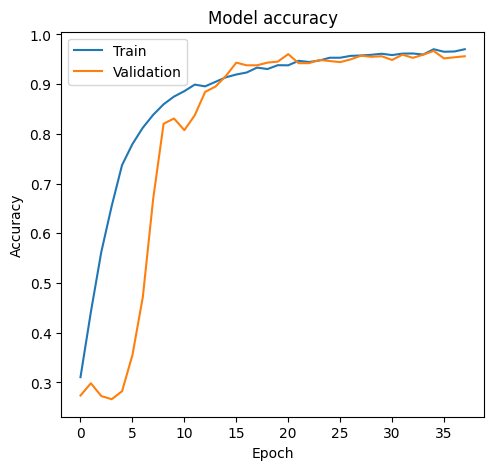

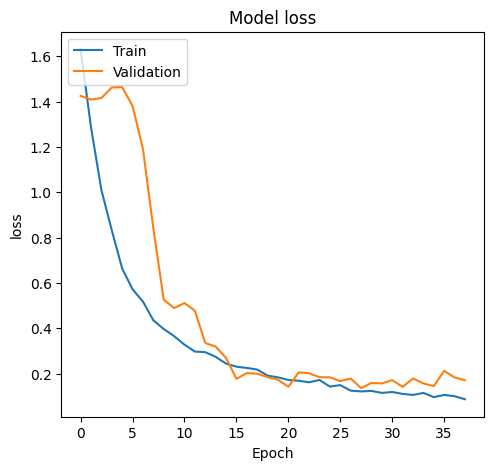

In [17]:
import matplotlib.pyplot as plt

#plot training & validation accuracy values

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')

#plot training & validation loss values

plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Train','Validation'],loc='upper left')

plt.show

**Evaluate the model**

In [18]:
test_loss,test_accuracy=model.evaluate(X_test,y_test,verbose=1)
print("\nTest accuracy:",test_accuracy)


18/18 [==============================] - 1s 63ms/step - loss: 0.1610 - accuracy: 0.9514

Test accuracy: 0.9513888955116272


**Confusion matrix**

<function matplotlib.pyplot.show(close=None, block=None)>

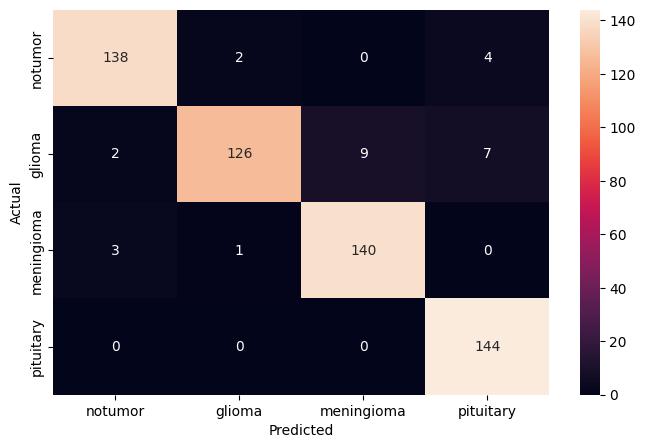

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_true,y_predict_classes)
plt.figure(figsize=(8,5))
sns.heatmap(cm,annot=True,fmt='.0f',xticklabels=['notumor','glioma','meningioma','pituitary'],yticklabels=['notumor','glioma','meningioma','pituitary'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

**Test the model's prediction ability using external image**

In [20]:
from PIL import Image
from io import BytesIO
import requests
import tensorflow as tf

#Load and preprocess the image from URL
url="https://www.aboutcancer.com/mri_gbm3.jpg"
response=requests.get(url)
img=Image.open(BytesIO(response.content)).convert('RGB')
test_image=img.resize((128,128))
test_image=img_to_array(test_image)
test_image/=255.0 #normalize the image
test_image=np.expand_dims(test_image,axis=0)

#Confirm that the shape of the image is correct
print('Inpur image shape:',test_image.shape)

prediction=model.predict(test_image)
predicted_class=encoder.classes_[np.argmax(prediction)]

print("Prediction class:",predicted_class)

Inpur image shape: (1, 128, 128, 3)
1/1 [==============================] - 3s 3s/step
Prediction class: meningioma
